In [1]:
%config Completer.use_jedi = False

import sys
sys.path.insert(1,'../')
sys.path.insert(1,'../contour_integ_models/')


# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')


# Pytorch related
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data as dt
from torchinfo import summary
import torchvision.models as pretrained_models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo
from torch.autograd import Variable



# Numpy, Matplotlib, Pandas, Sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

from scipy.spatial import distance
from scipy.stats.stats import pearsonr
from scipy import stats

%matplotlib inline 


# python utilities
from itertools import combinations
import gc
import pickle
from tqdm import tqdm_notebook as tqdm
import copy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import networkx as nx
import os
from IPython.display import Image
from IPython.core.debugger import set_trace
import collections
from functools import partial
import math
import time
import glob

from PIL import Image, ImageStat
from matplotlib.pyplot import imshow

# Extra imports
from lib.feature_extractor import FeatureExtractor
from lib.custom_dataset import Contour_Dataset
from lib.build_fe_ft_models import *
from lib.misc_functions import *
from lib.field_stim_functions import *




updated june4


# Hyperparameters

In [2]:
img_dim=512

batch_size=32
num_workers=8
device = torch.device('cuda:'+'3')
# device = 'cpu'

print(device)

cuda:3


### Extract all the values from the config variables

In [3]:
from visualdiet_savedmodel_config import *

print('\n Visual Diet config \n')
print(visual_diet_config)


 Visual Diet config 

{'root_directory': '/home/jovyan/work/Datasets/contour_integration/model-training/config_0/', 'get_B': [0, 15, 30, 45, 60, 75], 'get_D': [32], 'get_A': [0], 'get_numElements': [12]}


In [4]:
root_directory=visual_diet_config['root_directory']
get_B=visual_diet_config['get_B']
get_D=visual_diet_config['get_D']
get_A=visual_diet_config['get_A']
get_numElements=visual_diet_config['get_numElements']

### Data Transforms

In [5]:
# normalize images using parameters from the training image set
data_transform = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

data_transform_without_norm = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor()                    
 ])

# Helper functions

In [6]:
def compute_diff_means(arr1, arr2):
    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)
    
    return (mean1 - mean2)

def compute_dprime_means(arr1, arr2):
    """
    Compute d' based on the difference of means divided by the pooled standard deviation.
    """
    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)
    
    var1 = np.var(arr1, ddof=1)  # ddof=1 for sample variance
    var2 = np.var(arr2, ddof=1)  # ddof=1 for sample variance
    
    # Calculate the pooled standard deviation
    pooled_std = np.sqrt((var1 + var2) / 2)
    
    # Compute d'
    d_prime = (mean1 - mean2) / pooled_std
    
    return d_prime

def compute_aprime_means(arr1, arr2):
    """
    Compute A' as the area under the ROC curve based on two input arrays.
    """
    # Combine the arrays and create corresponding labels
    combined = np.concatenate((arr1, arr2))
    labels = np.concatenate((np.ones(len(arr1)), np.zeros(len(arr2))))
    
    # Compute AUC
    a_prime = roc_auc_score(labels, combined)
    
    return a_prime

In [7]:
def get_train_val_acc(files):
    all_models_train_acc={}
    all_models_val_acc={}

    for f in files:
        checkpoint=torch.load(f)
        all_models_train_acc[checkpoint['training_config']['layer_name']]=checkpoint['metrics']['train_acc'][-1]
        all_models_val_acc[checkpoint['training_config']['layer_name']]=checkpoint['metrics']['val_acc'][-1]



    myKeys = list(all_models_train_acc.keys())
    myKeys.sort()
    all_models_train_acc = {i: all_models_train_acc[i] for i in myKeys}



    myKeys = list(all_models_val_acc.keys())
    myKeys.sort()
    all_models_val_acc = {i: all_models_val_acc[i] for i in myKeys}
    
    
    return all_models_train_acc,all_models_val_acc

def get_list_acc(acc_dict,list_layers):
    acc=[]
    for i in range(len(list_layers)):
        # layer=list_layers[i].replace('_','.')
        layer=list_layers[i]
        if layer in acc_dict.keys():
            acc.append(acc_dict[layer])
            
    return acc


def get_prediction(model_file_paths):
    model_valacc_scores={}
    for file in tqdm(model_file_paths):

        # Model
        checkpoint=torch.load(file)
        # loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device='cpu')
        loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
        loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
        
        change_train_eval_mode(loaded_spliced_model,loaded_spliced_model.fine_tune,train_eval_mode='eval')




        model_valacc_scores[checkpoint['training_config']['layer_name']]=np.array([])
        for (inputs, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm,disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs= loaded_spliced_model.forward(inputs)
            _, preds = torch.max(outputs, 1)

            model_valacc_scores[checkpoint['training_config']['layer_name']]=np.concatenate((model_valacc_scores[checkpoint['training_config']['layer_name']],(preds == labels).float().cpu().numpy()))
    
    
    return model_valacc_scores

def get_list_acc_mean_std_ci(sal_dict,list_layers):
    mean_sal=[]
    std_sal=[]
    confint_sal=[]
    
    
    confint_lower=[]
    confint_upper=[]
    
    for i in range(len(list_layers)):
        # layer=list_layers[i].replace('_','.')
        layer=list_layers[i]
        if layer in sal_dict.keys():
            mean_sal.append(np.mean(sal_dict[layer]))
            
            std_sal.append(np.std(sal_dict[layer],ddof=1))
            
            confint_sal.append(1.96*(np.std(sal_dict[layer],ddof=1) / np.sqrt(len(sal_dict[layer]))))
            
            confint_lower.append(np.percentile(sal_dict[layer], 2.5))
            confint_upper.append(np.percentile(sal_dict[layer], 97.5))
            
    return mean_sal,std_sal,confint_sal,confint_lower,confint_upper


# COMPLETED WORK

# Figure : Fig. 2A
## Description: Contour Readout Accuracies for Finetune, Frozen and Random Alexnet

### Setup the dataset and set of models

In [ ]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)


### Collecting the accuracy data for all models over the validation images

In [ ]:
sup_regular_finetune_files = glob.glob("../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/*finetune.pt")
sup_regular_finetune_acc={'train':get_train_val_acc(sup_regular_finetune_files)[0],'val':get_train_val_acc(sup_regular_finetune_files)[1]}
sup_regular_finetune_predictions=get_prediction(sup_regular_finetune_files)

In [ ]:
sup_regular_frozen_files =  glob.glob("../model_weights/contour_model_weights/alexnet_regimagenet_categ_frozen_broad/*frozen.pt")
sup_regular_frozen_acc={'train':get_train_val_acc(sup_regular_frozen_files)[0],'val':get_train_val_acc(sup_regular_frozen_files)[1]}
sup_regular_frozen_predictions=get_prediction(sup_regular_frozen_files)



In [ ]:
random_regular_frozen_files =  glob.glob("../model_weights/contour_model_weights/alexnet-random-nodata-notask_frozen_broad/*frozen.pt")
random_regular_frozen_acc={'train':get_train_val_acc(random_regular_frozen_files)[0],'val':get_train_val_acc(random_regular_frozen_files)[1]}
random_regular_frozen_predictions=get_prediction(random_regular_frozen_files)



### Plotting all the accuracy data

In [ ]:
list_layers=['features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

for i in range(len(list_layers)):
    list_layers[i]=list_layers[i].replace('_','.')

In [ ]:
plt.figure(figsize=(14,10))


spacing_x=2
jitter_stylized=0.4

color_or_finetune=(78/255,121/255,180/255)
color_or_frozen=(209/255,111/255,28/255)
color_stylized_frozen=(231/255,168/255,34/255)

error_bar_width=3
error_bar_cap=4



mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(sup_regular_finetune_predictions,list_layers)
plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='o', marker='o', color=color_or_finetune, markersize=10, 
             label='or finetune', alpha=0.8)




mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(sup_regular_frozen_predictions,list_layers)
plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='s', marker='o', color=color_or_frozen, markersize=10, 
             label='or frozen', alpha=0.8)



mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(random_regular_frozen_predictions,list_layers)
plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='d', marker='o', color='gray', markersize=10, 
             label='random frozen', alpha=0.8)



plt.axhline(y=0.5,linestyle='--',alpha=0.3,color='r',label='chance')


# for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
#     plt.axvline(i*2,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))) * spacing_x,list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.show()
    
    

# Figure : Fig. 2B and SFig. 2A 
## Description: Location Sensitivity for avgpool and conv2 finetuned models

In [ ]:
def get_data(model_file, beta_val=15,img_num=4):
    
    
    ### Show the image
    val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=[beta_val],get_D=get_D,get_A=get_A,get_numElements=get_numElements)
    val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    val_dataset_without_norm = Contour_Dataset(root=root_directory,transform=data_transform_without_norm,train=False,get_B=[beta_val],get_D=get_D,get_A=get_A,get_numElements=get_numElements)
    val_loader_without_norm = torch.utils.data.DataLoader(dataset=val_dataset_without_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)


    
    
    a, b, d, alpha, nel, labels, record =next(iter(val_loader_norm))
    prep_img=torch.unsqueeze(a[img_num],0)
    print('Beta Val: ',b[img_num])
    print('Contour Present: ',labels[img_num])
    prep_img=prep_img.to(device)
    prep_img=Variable(prep_img,requires_grad=True)
    
    ## Plot the orginal image - this is the normalized one, the one that will actually be used
    # original_img=np.transpose(prep_img[0].detach().cpu().numpy(),(1,2,0))
    # plt.figure(figsize=(10,8))
    # plt.imshow(original_img)
    # plt.close()
    
    
    
    ## Plot the orginal unnormalized image
    plt.figure(figsize=(10,8))
    a_without_norm,b, d, alpha, nel, labels, record=next(iter(val_loader_without_norm))
    plt.imshow(np.transpose(torch.unsqueeze(a_without_norm[img_num],0)[0].numpy(),(1,2,0)))
    plt.title('Original Image - visualizing unnormalized image here')
    plt.axis('off')
    plt.show()
    # plt.savefig('./dev/ccn_figures/poster/original_image.png', bbox_inches='tight',dpi=300) 
    # plt.close()
    

    checkpoint=torch.load(model_file)

    ####################################################################################################
    ## Showing the Model Stats
    print('Base Model is',checkpoint['training_config']['base_model_name'])
    print('Layer Readout is',checkpoint['training_config']['layer_name'])
    print('Final Val Accuracy is',checkpoint['metrics']['val_acc'][-1])
    ####################################################################################################




    ####################################################################################################
    ## Loading the model and setting up the Guided Spliced Model for Attention Maps
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    GBP = Spliced_GuidedBackprop(loaded_spliced_model,device)
    ####################################################################################################




    ####################################################################################################
    ## Getting the Saliency Maps
    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, 1)


    # Gradients
    guided_grads_vis = guided_grads - guided_grads.min()
    guided_grads_vis /= guided_grads_vis.max()

#     plt.figure(figsize=(20,16))
    
    
#     plt.subplot(2,2,3)
#     plt.imshow(np.transpose(guided_grads_vis,(1,2,0)))
#     plt.axis('off')


    # Grayscale Gradients
    grayscale_guided_grads = convert_to_grayscale(guided_grads)


    grayscale_guided_grads_vis = grayscale_guided_grads - grayscale_guided_grads.min()
    grayscale_guided_grads_vis /= grayscale_guided_grads_vis.max()

    
    
    plt.figure(figsize=(20,16))
    
    
    plt.subplot(2,2,3)
    plt.imshow(np.transpose(guided_grads_vis,(1,2,0)))
    plt.title('Saliency Map overlayed on image')
    plt.axis('off')
    
    plt.subplot(2,2,4)
    plt.imshow(np.squeeze(np.transpose(grayscale_guided_grads_vis,(1,2,0))),cmap='gray')
    plt.title('Saliency Map')
    plt.axis('off')



    ## Compute saliency maps
    print(grayscale_guided_grads_vis.shape)
    viz_image=grayscale_guided_grads_vis[0]
    ####################################################################################################





    ####################################################################################################
    ## Compute saliency scores
    mask_img_path_fg, mask_img_path_bg, list_gauss=mask_renderer(torch.load(record[img_num]),140)
    mask_img_path_fg=np.array(mask_img_path_fg)
    mask_img_path_bg=np.array(mask_img_path_bg)

    
    plt.subplot(2,2,1)
    plt.imshow(mask_img_path_fg,cmap='gray')
    plt.title('Contour Element Locations')
    plt.axis('off')

    plt.subplot(2,2,2)
    plt.imshow(mask_img_path_bg,cmap='gray')
    plt.title('Background Element Locations')
    plt.axis('off')
    plt.show()


    saliency_score_diffmean=compute_diff_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_dprime=compute_dprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_aprime=compute_aprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])


    print('saliency_score_diffmean: \t', saliency_score_diffmean)
    print('saliency_score_diffmean: \t', saliency_score_dprime)
    print('saliency_score_diffmean: \t',saliency_score_aprime)
    ####################################################################################################
        

In [ ]:
get_data(model_file='../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_features-3_mode_finetune.pt')

In [ ]:
get_data(model_file='../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt')

# Figure : Fig. 2D and SFig. 2C-Inset 

## Description: Alignment Sensitivity for avgpool finetuned model
This analysis takes roughly 25 minutes to complete on 600 validation images when run on the contour model reading out from avgpool layer of Alexnet




### Select the dataset

In [ ]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
# val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=1, num_workers=num_workers, shuffle=False)
print(len(val_dataset_norm))

### Select the model from the saved model directory

In [ ]:
selected_file='../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt'
print(selected_file)

### Computing the Saliency for all images

In [ ]:
def compute_saliency(prep_img,prep_recorder,file):
    prep_img=Variable(prep_img,requires_grad=True).to(device)

    
    
    
    ####################################################################################################
    ## Loading the model and setting up the Guided Spliced Model for Attention Maps   
    ## Model
    checkpoint=torch.load(selected_file)
    
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)

    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    GBP = Spliced_GuidedBackprop(loaded_spliced_model,device)
    ####################################################################################################

    
    
    
    

    ####################################################################################################
    ## Getting the Saliency Maps
    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, 1)
    # Gradients
    guided_grads_vis = guided_grads - guided_grads.min()
    guided_grads_vis /= guided_grads_vis.max()

    # Grayscale Gradients
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    grayscale_guided_grads_vis = grayscale_guided_grads - grayscale_guided_grads.min()
    grayscale_guided_grads_vis /= grayscale_guided_grads_vis.max()
    
    
    viz_image=grayscale_guided_grads_vis[0]
    ####################################################################################################

    
    
    
    
    ####################################################################################################
    ## Compute saliency scores
    mask_img_path_fg, mask_img_path_bg, list_gauss=mask_renderer(torch.load(prep_recorder),140)
    mask_img_path_fg=np.array(mask_img_path_fg)
    mask_img_path_bg=np.array(mask_img_path_bg)
    
    
    
    saliency_score_diffmean=compute_diff_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_dprime=compute_dprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_aprime=compute_aprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    ####################################################################################################
    
    
    
    
    
    ####################################################################################################
    ## Making the run more memory efficient
    loaded_spliced_model=loaded_spliced_model.to('cpu')
    del GBP
    torch.cuda.empty_cache()
    gc.collect()
    ####################################################################################################
    
    
    
    return saliency_score_diffmean,saliency_score_dprime,saliency_score_aprime

In [ ]:
all_saliency_score_diff=[]
all_saliency_score_dprime=[]
all_saliency_score_aprime=[]

all_betas=[]
all_labels=[]

for (a, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm):
    for img_num in tqdm(range(a.shape[0]),disable=True):
        
        prep_img=torch.unsqueeze(a[img_num],0)
        prep_recorder=record[img_num]
        
        saliency_score_diffmean,saliency_score_dprime,saliency_score_aprime=compute_saliency(prep_img,prep_recorder,selected_file)
        
        all_saliency_score_diff.append(saliency_score_diffmean)
        all_saliency_score_dprime.append(saliency_score_dprime)
        all_saliency_score_aprime.append(saliency_score_aprime)
        
        
        
    all_betas.append(b)
    all_labels.append(labels)

all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()
all_saliency_score_diff=np.array(all_saliency_score_diff)
all_saliency_score_dprime=np.array(all_saliency_score_dprime)
all_saliency_score_aprime=np.array(all_saliency_score_aprime)

### Plotting the scores

In [ ]:
contour_present_pos=np.where(all_labels==1)[0]
contour_absent_pos=np.where(all_labels==0)[0]


### Alignment Sensitivity via Diff. of Means Measure

In [ ]:
# Create a figure
fig = plt.figure(figsize=(16,10))
# Create a GridSpec object
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])



# First subplot: Left column, spanning both rows
ax1 = plt.subplot(gs[:, 0])

# Second subplot: Top-right corner
ax2 = plt.subplot(gs[0, 1])

# Third subplot: Bottom-right corner
ax3 = plt.subplot(gs[1, 1])






# First subplot: Left column, spanning both rows
# Scatter Plot with Connecting Lines
for x1, x2 in zip(all_saliency_score_diff[contour_absent_pos], all_saliency_score_diff[contour_present_pos]):
    ax1.plot([1, 4], [x1, x2], 'ko-', markersize=8,alpha=0.09)
ax1.set_xticks([1, 4], ['Contour absent', 'Contour present'])
ax1.set_xlim(0,5)
ax1.set_ylabel('saliency_score_diffmean')
ax1.set_title('Contour Sensitivity using Diff. Means')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)






# Second subplot: Top-right corner
sns.distplot(all_saliency_score_diff[contour_present_pos], ax=ax2, label='contour_present',color='green')
sns.distplot(all_saliency_score_diff[contour_absent_pos], ax=ax2, label='contour_absent',color='gray')
ax2.set_title('Contour Sensitivity using Diff. Means (Histogram)')
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)





# Third subplot: Bottom-right corner
sns.distplot(all_saliency_score_diff[contour_present_pos] - all_saliency_score_diff[contour_absent_pos], ax=ax3, label='difference',color='k')
ax3.set_title('Alignment Sensitivity using Diff. Means')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
plt.show()



# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(all_saliency_score_diff[contour_present_pos], all_saliency_score_diff[contour_absent_pos])
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

### Alignment Sensitivity via DPrime Measure

In [ ]:
# Create a figure
fig = plt.figure(figsize=(16,10))
# Create a GridSpec object
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])



# First subplot: Left column, spanning both rows
ax1 = plt.subplot(gs[:, 0])

# Second subplot: Top-right corner
ax2 = plt.subplot(gs[0, 1])

# Third subplot: Bottom-right corner
ax3 = plt.subplot(gs[1, 1])






# First subplot: Left column, spanning both rows
# Scatter Plot with Connecting Lines
for x1, x2 in zip(all_saliency_score_dprime[contour_absent_pos], all_saliency_score_dprime[contour_present_pos]):
    ax1.plot([1, 4], [x1, x2], 'ko-', markersize=8,alpha=0.09)
ax1.set_xticks([1, 4], ['Contour absent', 'Contour present'])
ax1.set_xlim(0,5)
ax1.set_ylabel('saliency_score_dprime')
ax1.set_title('Contour Sensitivity using DPrime')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)






# Second subplot: Top-right corner
sns.distplot(all_saliency_score_dprime[contour_present_pos], ax=ax2, label='contour_present',color='green')
sns.distplot(all_saliency_score_dprime[contour_absent_pos], ax=ax2, label='contour_absent',color='gray')
ax2.set_title('Contour Sensitivity using DPrime (Histogram)')
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)





# Third subplot: Bottom-right corner
sns.distplot(all_saliency_score_dprime[contour_present_pos] - all_saliency_score_dprime[contour_absent_pos], ax=ax3, label='difference',color='k')
ax3.set_title('Alignment Sensitivity using DPrime')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
plt.show()



# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(all_saliency_score_dprime[contour_present_pos], all_saliency_score_dprime[contour_absent_pos])
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

### Alignment Sensitivity via APrime Measure

In [ ]:
# Create a figure
fig = plt.figure(figsize=(16,10))
# Create a GridSpec object
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])



# First subplot: Left column, spanning both rows
ax1 = plt.subplot(gs[:, 0])

# Second subplot: Top-right corner
ax2 = plt.subplot(gs[0, 1])

# Third subplot: Bottom-right corner
ax3 = plt.subplot(gs[1, 1])






# First subplot: Left column, spanning both rows
# Scatter Plot with Connecting Lines
for x1, x2 in zip(all_saliency_score_aprime[contour_absent_pos], all_saliency_score_aprime[contour_present_pos]):
    ax1.plot([1, 4], [x1, x2], 'ko-', markersize=8,alpha=0.09)
ax1.set_xticks([1, 4], ['Contour absent', 'Contour present'])
ax1.set_xlim(0,5)
ax1.set_ylabel('saliency_score_aprime')
ax1.set_title('Contour Sensitivity using APrime')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)






# Second subplot: Top-right corner
sns.distplot(all_saliency_score_aprime[contour_present_pos], ax=ax2, label='contour_present',color='green')
sns.distplot(all_saliency_score_aprime[contour_absent_pos], ax=ax2, label='contour_absent',color='gray')
ax2.set_title('Contour Sensitivity using APrime (Histogram)')
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)





# Third subplot: Bottom-right corner
sns.distplot(all_saliency_score_aprime[contour_present_pos] - all_saliency_score_aprime[contour_absent_pos], ax=ax3, label='difference',color='k')
ax3.set_title('Alignment Sensitivity using APrime')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
plt.show()



# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(all_saliency_score_aprime[contour_present_pos], all_saliency_score_aprime[contour_absent_pos])
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Figure : SFig. 2B and SFig. 2C 

## Description: Location and Alignment Sensitivity for all layers of finetuned alexnet over broad curvatures
This analysis takes roughly 8 hours minutes to complete on 600 validation images when run on all contour readout models (with object recognition alexnet finetuned backbones and trained on braod contour curvatures) 

### Setup the dataset and set of models

In [ ]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)
print(len(val_dataset_norm))

In [ ]:
model_file_paths=sorted(glob.glob('../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/*.pt'))

In [ ]:
for i,file in enumerate(model_file_paths):
    print(i,file)

### Computing the Saliency for all images

In [ ]:
def compute_saliency(prep_img,prep_recorder,file):
    prep_img=Variable(prep_img,requires_grad=True).to(device)

    
    
    
    ####################################################################################################
    ## Loading the model and setting up the Guided Spliced Model for Attention Maps   
    ## Model
    checkpoint=torch.load(selected_file)
    
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)

    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    GBP = Spliced_GuidedBackprop(loaded_spliced_model,device)
    ####################################################################################################

    
    
    
    

    ####################################################################################################
    ## Getting the Saliency Maps
    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, 1)
    # Gradients
    guided_grads_vis = guided_grads - guided_grads.min()
    guided_grads_vis /= guided_grads_vis.max()

    # Grayscale Gradients
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    grayscale_guided_grads_vis = grayscale_guided_grads - grayscale_guided_grads.min()
    grayscale_guided_grads_vis /= grayscale_guided_grads_vis.max()
    
    
    viz_image=grayscale_guided_grads_vis[0]
    ####################################################################################################

    
    
    
    
    ####################################################################################################
    ## Compute saliency scores
    mask_img_path_fg, mask_img_path_bg, list_gauss=mask_renderer(torch.load(prep_recorder),140)
    mask_img_path_fg=np.array(mask_img_path_fg)
    mask_img_path_bg=np.array(mask_img_path_bg)
    
    
    
    saliency_score_diffmean=compute_diff_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_dprime=compute_dprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_aprime=compute_aprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    ####################################################################################################
    
    
    
    
    
    ####################################################################################################
    ## Making the run more memory efficient
    loaded_spliced_model=loaded_spliced_model.to('cpu')
    del GBP
    torch.cuda.empty_cache()
    gc.collect()
    ####################################################################################################
    
    
    
    return saliency_score_diffmean,saliency_score_dprime,saliency_score_aprime

### Running the loop - All models, All images

In [ ]:
model_saliency_score_diff={}
model_saliency_score_dprime={}
model_saliency_score_aprime={}


for file in tqdm(model_file_paths):
    print(file)
    checkpoint=torch.load(file)
    
    model_saliency_score_diff[checkpoint['training_config']['layer_name']]=[]
    model_saliency_score_dprime[checkpoint['training_config']['layer_name']]=[]
    model_saliency_score_aprime[checkpoint['training_config']['layer_name']]=[]
    
    for (a, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm,disable=True):
        
        
        for img_num in tqdm(range(a.shape[0]),disable=True):
            prep_img=torch.unsqueeze(a[img_num],0)
            prep_recorder=record[img_num]
            
            saliency_score_diffmean,saliency_score_dprime,saliency_score_aprime=compute_saliency(prep_img,prep_recorder,file)

            model_saliency_score_diff[checkpoint['training_config']['layer_name']].append(saliency_score_diffmean)
            model_saliency_score_dprime[checkpoint['training_config']['layer_name']].append(saliency_score_dprime)
            model_saliency_score_aprime[checkpoint['training_config']['layer_name']].append(saliency_score_aprime)
            
        
        
    model_saliency_score_diff[checkpoint['training_config']['layer_name']]=np.array(model_saliency_score_diff[checkpoint['training_config']['layer_name']])
    model_saliency_score_dprime[checkpoint['training_config']['layer_name']]=np.array(model_saliency_score_dprime[checkpoint['training_config']['layer_name']])
    model_saliency_score_aprime[checkpoint['training_config']['layer_name']]=np.array(model_saliency_score_aprime[checkpoint['training_config']['layer_name']])
    
    

In [ ]:
all_betas=[]
all_labels=[]

for (a, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm,disable=True):
    all_betas.append(b)
    all_labels.append(labels)

    
all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()

In [ ]:
print(model_saliency_score_diff.keys())
print(model_saliency_score_dprime.keys())
print(model_saliency_score_aprime.keys())

In [ ]:
contour_present_pos=np.where(all_labels==1)[0]
contour_absent_pos=np.where(all_labels==0)[0]


### Plotting for all readouts

In [ ]:
def get_foreground_sensitivity_allmodels(sal_dict,list_layers,pos):
    mean_sal=[]
    std_sal=[]
    confint_sal=[]
    confint_lower=[]
    confint_upper=[]
    
    
    
    for i in range(len(list_layers)):
        layer=list_layers[i]
        
        
        if layer in sal_dict.keys():
            
            
            mean_sal.append(np.mean(sal_dict[layer][pos]))
            std_sal.append(np.std(sal_dict[layer][pos],ddof=1))
            
            
            
            confint_sal.append(1.96*(np.std(sal_dict[layer][pos],ddof=1) / np.sqrt(len(sal_dict[layer][pos]))))
            confint_lower.append(np.percentile(sal_dict[layer][pos], 2.5))
            confint_upper.append(np.percentile(sal_dict[layer][pos], 97.5))
            
    return mean_sal,std_sal,confint_sal,confint_lower,confint_upper


In [ ]:
def get_alignment_sensitivity_allmodels(sal_dict,list_layers,present_pos,absent_pos):
    
    mean_sal=[]
    std_sal=[]
    confint_sal=[]
    confint_lower=[]
    confint_upper=[]
    
    
    
    for i in range(len(list_layers)):
        layer=list_layers[i]
        
        
        if layer in sal_dict.keys():
            
            
            diff_values=sal_dict[layer][present_pos] - sal_dict[layer][absent_pos]
            
            mean_sal.append(np.mean(diff_values))
            std_sal.append(np.std(diff_values))
            
            
            
            confint_sal.append(1.96*(np.std(diff_values) / np.sqrt(len(diff_values))))
            confint_lower.append(np.percentile(diff_values, 2.5))
            confint_upper.append(np.percentile(diff_values, 97.5))
            
    return mean_sal,std_sal,confint_sal,confint_lower,confint_upper


In [ ]:
list_layers=['features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

for i in range(len(list_layers)):
    list_layers[i]=list_layers[i].replace('_','.')

In [ ]:
contour_present_pos=np.where(all_labels==1)[0]
contour_absent_pos=np.where(all_labels==0)[0]

In [ ]:
mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_foreground_sensitivity_allmodels(model_saliency_score_diff,list_layers,contour_present_pos)



plt.figure(figsize=(22,10))
color_or_finetune=(78/255,121/255,180/255)
spacing_x=2
error_bar_width=3
error_bar_cap=4

plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='o',marker='o', color=color_or_finetune, markersize=10, 
             label='or finetune', alpha=0.8)





plt.xticks(np.arange(len(mean_sal)) * spacing_x,list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 


plt.ylabel('Diff of means',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Location Sensitivity in Contour Images using Diff. of Means measure',fontsize=15)
plt.show()
    
    
    
    

In [ ]:
mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_foreground_sensitivity_allmodels(model_saliency_score_aprime,list_layers,contour_present_pos)



plt.figure(figsize=(22,10))
color_or_finetune=(78/255,121/255,180/255)
spacing_x=2
error_bar_width=3
error_bar_cap=4

plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='o',marker='o', color=color_or_finetune, markersize=10, 
             label='or finetune', alpha=0.8)





plt.xticks(np.arange(len(mean_sal)) * spacing_x,list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 


plt.ylabel('Aprime',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Location Sensitivity in Contour Images using APrime measure',fontsize=15)
plt.show()
    
    
    
    

In [ ]:
mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_alignment_sensitivity_allmodels(model_saliency_score_aprime,list_layers,contour_present_pos,contour_absent_pos)

plt.figure(figsize=(22,10))
color_or_finetune=(78/255,121/255,180/255)
spacing_x=2
error_bar_width=3
error_bar_cap=4

plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='o',marker='o', color=color_or_finetune, markersize=10, 
             label='or finetune', alpha=0.8)





plt.xticks(np.arange(len(mean_sal)) * spacing_x,list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 


plt.ylabel('Difference b/w misaligned and aligned pairs',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Alignment Sensitivity in Contour Images using APrime measure',fontsize=15)
plt.show()
    


# Figure : Fig. 3 and SFig. 3 

## Description: Performance of PinholeNets

In [8]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=1, num_workers=num_workers, shuffle=False)


In [9]:
def pinholenet_get_prediction(model_file_paths):
    model_valacc_scores={}
    for file in tqdm(model_file_paths):

        # Model
        checkpoint=torch.load(file)
        # loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device='cpu')
        loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
        loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
        
        change_train_eval_mode(loaded_spliced_model,loaded_spliced_model.fine_tune,train_eval_mode='eval')




        model_valacc_scores[file.split('/')[-1]]=np.array([])
        for (inputs, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm,disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs= loaded_spliced_model.forward(inputs)
            _, preds = torch.max(outputs, 1)

            model_valacc_scores[file.split('/')[-1]]=np.concatenate((model_valacc_scores[file.split('/')[-1]],(preds == labels).float().cpu().numpy()))
    
    
    return model_valacc_scores

In [10]:
def pinholenet_get_list_acc_mean_std_ci(sal_dict):
    mean_sal=[]
    std_sal=[]
    confint_sal=[]
    
    
    confint_lower=[]
    confint_upper=[]
    
    list_keys=[]
    
    for key in sal_dict.keys():
        
        
        mean_sal.append(np.mean(sal_dict[key]))

        std_sal.append(np.std(sal_dict[key],ddof=1))

        confint_sal.append(1.96*(np.std(sal_dict[key],ddof=1) / np.sqrt(len(sal_dict[key]))))

        confint_lower.append(np.percentile(sal_dict[key], 2.5))
        confint_upper.append(np.percentile(sal_dict[key], 97.5))
        
        list_keys.append(key)
            
    return mean_sal,std_sal,confint_sal,confint_lower,confint_upper, list_keys


### Collecting all the accuracy data

In [16]:
bagnet_conv5_finetune_files = ['../model_weights/contour_model_weights/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_features-9_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_features-9_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_features-9_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_features-9_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_features-12_mode_finetune.pt']
bagnet_conv5_finetune_predictions=pinholenet_get_prediction(bagnet_conv5_finetune_files)

In [30]:
bagnet_ap_finetune_files = ['../model_weights/contour_model_weights/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_avgpool_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_avgpool_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_avgpool_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_avgpool_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt']
bagnet_ap_finetune_predictions=pinholenet_get_prediction(bagnet_ap_finetune_files)








bagnet_fc1_finetune_files = ['../model_weights/contour_model_weights/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_classifier-2_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_classifier-2_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_classifier-2_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_classifier-2_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-2_mode_finetune.pt']
bagnet_fc1_finetune_predictions=pinholenet_get_prediction(bagnet_fc1_finetune_files)







bagnet_fc2_finetune_files = ['../model_weights/contour_model_weights/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_classifier-5_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_classifier-5_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_classifier-5_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_classifier-5_mode_finetune.pt',
                        '../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-5_mode_finetune.pt']
bagnet_fc2_finetune_predictions=pinholenet_get_prediction(bagnet_fc2_finetune_files)

  0%|          | 0/5 [00:00<?, ?it/s]

... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet11_72211_final_weights_pytorch2-d37f3073cd.pth
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet17_93311_final_weights_pytorch2-b051786873.pth
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet31_115333_final_weights_pytorch2-25355f56ff.pth
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Har

  0%|          | 0/5 [00:00<?, ?it/s]

... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet11_72211_final_weights_pytorch2-d37f3073cd.pth
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet17_93311_final_weights_pytorch2-b051786873.pth
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet31_115333_final_weights_pytorch2-25355f56ff.pth
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Har

  0%|          | 0/5 [00:00<?, ?it/s]

... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet11_72211_final_weights_pytorch2-d37f3073cd.pth
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet17_93311_final_weights_pytorch2-b051786873.pth
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet31_115333_final_weights_pytorch2-25355f56ff.pth
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Har

In [31]:
bagnet_conv5_mean_sal, _, bagnet_conv5_confint_sal, _, _, _ = pinholenet_get_list_acc_mean_std_ci(bagnet_conv5_finetune_predictions)


bagnet_ap_mean_sal, _, bagnet_ap_confint_sal, _, _, _ = pinholenet_get_list_acc_mean_std_ci(bagnet_ap_finetune_predictions)


bagnet_fc1_mean_sal, _, bagnet_fc1_confint_sal, _, _, _ = pinholenet_get_list_acc_mean_std_ci(bagnet_fc1_finetune_predictions)


bagnet_fc2_mean_sal, _, bagnet_fc2_confint_sal, _, _, _ = pinholenet_get_list_acc_mean_std_ci(bagnet_fc2_finetune_predictions)


In [32]:
color_shades_barplot=[(0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
                      (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
                      (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
                      (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
                      (0.8275, 0.8275, 0.8275)]

### Fig. 3C

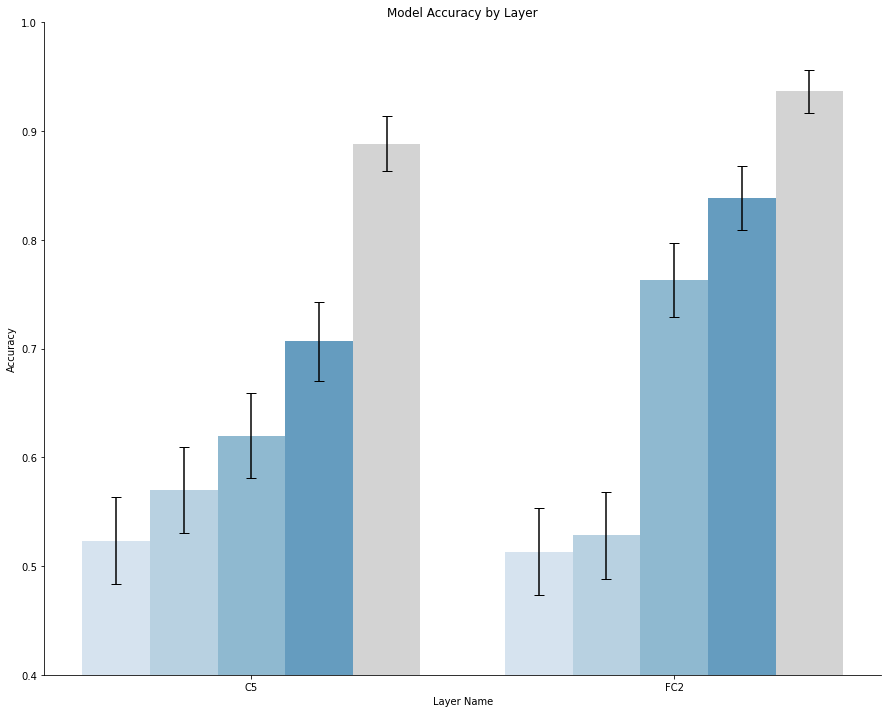

In [39]:
data = {
    'model_name': ['P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet'],
    
    'layer_name': ['C5', 'C5', 'C5', 'C5', 'C5',
                   'FC2','FC2','FC2','FC2','FC2'],
    
    'accuracy': [*bagnet_conv5_mean_sal,
                *bagnet_fc2_mean_sal],
    
    'error': [*bagnet_conv5_confint_sal,
                *bagnet_fc2_confint_sal],
    
    
}

df = pd.DataFrame(data)

# Sample colors with RGB values
color_dict = {
    'P 11*11': (0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
    'P 17*17': (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
    'P 31*31': (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
    'P 33*33': (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
    'Standard Alexnet':(0.827, 0.827, 0.827)
}

plt.figure(figsize=(15, 12))
barplot = sns.barplot(data=df, x='layer_name', y='accuracy', hue='model_name', palette=color_dict, ci=None)

# Adjust the ylim to make sure error bars are visible
plt.ylim(0.4, 1.0)

# Since we have grouped data, we need to adjust the way we access the error values.
# We'll use groupby and get_group to get the correct subsets.
for name, group in df.groupby(['layer_name', 'model_name']):
    layer_name, model_name = name
    group_data = df[(df['layer_name'] == layer_name) & (df['model_name'] == model_name)]
    
    # Get the positions of the bars for the current group
    positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches if p.get_height() == group_data['accuracy'].values[0]]
    
    # Plot the error bars for the current group
    plt.errorbar(positions, group_data['accuracy'], yerr=group_data['error'], fmt='none', c='k', capsize=5)

plt.title('Model Accuracy by Layer')
plt.xlabel('Layer Name')
plt.ylabel('Accuracy')

# Remove the legend if not needed
plt.legend(title='Model Name').remove()

# Spine visibility settings as before
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig('./dev/manuscript_figures/f3_bagnet_comparison.png', format='png', dpi=600)
plt.show()

### SFig. 3C

In [47]:
alexnetbase=torch.load('../model_weights/contour_model_weights/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_features-12_mode_finetune.pt')['metrics']['val_acc']

alexnetepoch50=torch.load('../model_weights/contour_model_weights/alexnet-epoch50_regimagenet_categ_finetune_broad/model_alexnet-epoch50-regim-categ_layer_features-12_mode_finetune.pt')['metrics']['val_acc']
alexnetepoch100=torch.load('../model_weights/contour_model_weights/alexnet-epoch100_regimagenet_categ_finetune_broad/model_alexnet-epoch100-regim-categ_layer_features-12_mode_finetune.pt')['metrics']['val_acc']

alexnet33=torch.load('../model_weights/contour_model_weights/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_features-9_mode_finetune.pt')['metrics']['val_acc']
alexnet31=torch.load('../model_weights/contour_model_weights/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_features-9_mode_finetune.pt')['metrics']['val_acc']

alexnet17=torch.load('../model_weights/contour_model_weights/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_features-9_mode_finetune.pt')['metrics']['val_acc']
alexnet11=torch.load('../model_weights/contour_model_weights/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_features-9_mode_finetune.pt')['metrics']['val_acc']



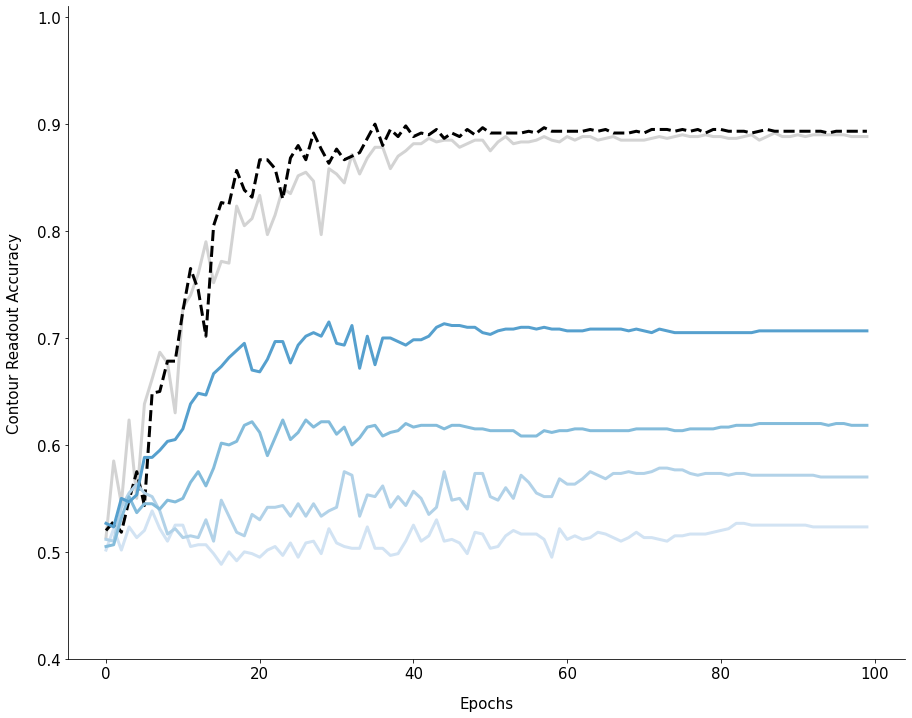

In [48]:
custom_colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a']

color_shades_barplot=[(0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
                      (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
                      (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
                      (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
                      (0.8275, 0.8275, 0.8275)]

plt.figure(figsize=(15,12))



l1,=plt.plot(np.arange(len(alexnetbase)),alexnetbase,linewidth=3.0,color='lightgray',label='alexnet torchvision baseline (90 epochs)')
# plt.plot(np.arange(len(alexnetepoch100)),alexnetepoch100,linewidth=1.0,color='k',label='alexnet-epoch100')
plt.plot(np.arange(len(alexnetepoch50)),alexnetepoch50,linestyle='--',linewidth=3.0,color='k',label='alexnet-epoch50')


plt.plot(np.arange(len(alexnet11)),alexnet11,linewidth=3.0,color=(0.8229757785467128, 0.8898269896193771, 0.9527566320645905),label='pinholenet-11')
plt.plot(np.arange(len(alexnet17)),alexnet17,linewidth=3.0,color=(0.6965013456362937, 0.8248366013071895, 0.9092656670511342),label='pinholenet-17')

plt.plot(np.arange(len(alexnet31)),alexnet31,linewidth=3.0,color=(0.5168627450980392, 0.7357477893118032, 0.8601922337562476),label='pinholenet-31')
plt.plot(np.arange(len(alexnet33)),alexnet33,linewidth=3.0,color=(0.3363783160322953, 0.6255132641291811, 0.8067358708189158),label='pinholenet-33')











# plt.axhline(y=0.5,linestyle='--',color='r',label='chance',alpha=0.1)

plt.xlabel('Epochs',fontsize=15,labelpad=15)
plt.ylabel('Contour Readout Accuracy',fontsize=15,labelpad=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)   
plt.ylim(0.4,1.01)

    
# plt.legend(fontsize=12,frameon=False)
plt.show()

### SFig. 3D

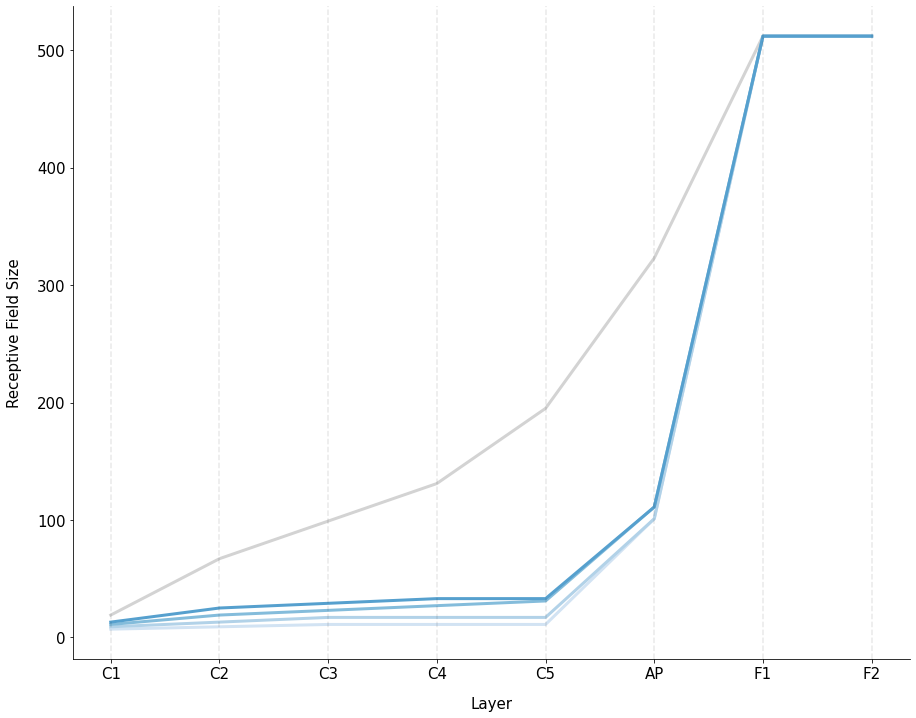

In [51]:
alexnet_base_rf=[19,67,99,131,195,323,512,512]
pinhole_11_rf=[7,9,11,11,11,101,512,512]
pinhole_17_rf=[9,13,17,17,17,101,512,512]
pinhole_31_rf=[11,19,23,27,31,111,512,512]
pinhole_33_rf=[13,25,29,33,33,111,512,512]


x_lab=['C1','C2','C3','C4','C5','AP','F1','F2']


plt.figure(figsize=(15,12))



plt.plot(np.arange(len(alexnet_base_rf)),alexnet_base_rf,linewidth=3.0,color='lightgray',label='standarad alexnet')

plt.plot(np.arange(len(pinhole_11_rf)),pinhole_11_rf,linewidth=3.0,color=(0.8229757785467128, 0.8898269896193771, 0.9527566320645905),label='pinholenet-11')
plt.plot(np.arange(len(pinhole_17_rf)),pinhole_17_rf,linewidth=3.0,color=(0.6965013456362937, 0.8248366013071895, 0.9092656670511342),label='pinholenet-17')
plt.plot(np.arange(len(pinhole_31_rf)),pinhole_31_rf,linewidth=3.0,color=(0.5168627450980392, 0.7357477893118032, 0.8601922337562476),label='pinholenet-31')
plt.plot(np.arange(len(pinhole_33_rf)),pinhole_33_rf,linewidth=3.0,color=(0.3363783160322953, 0.6255132641291811, 0.8067358708189158),label='pinholenet-33')


for i in range(len(np.arange(len(alexnet_base_rf)))):
    plt.axvline(np.arange(len(alexnet_base_rf))[i],linestyle='--',alpha=0.09,color='k')



plt.xticks(np.arange(len(alexnet_base_rf)),x_lab,fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Layer',fontsize=15,labelpad=15)
plt.ylabel('Receptive Field Size',fontsize=15,labelpad=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.legend().remove()
plt.show()

### SFig. 3E

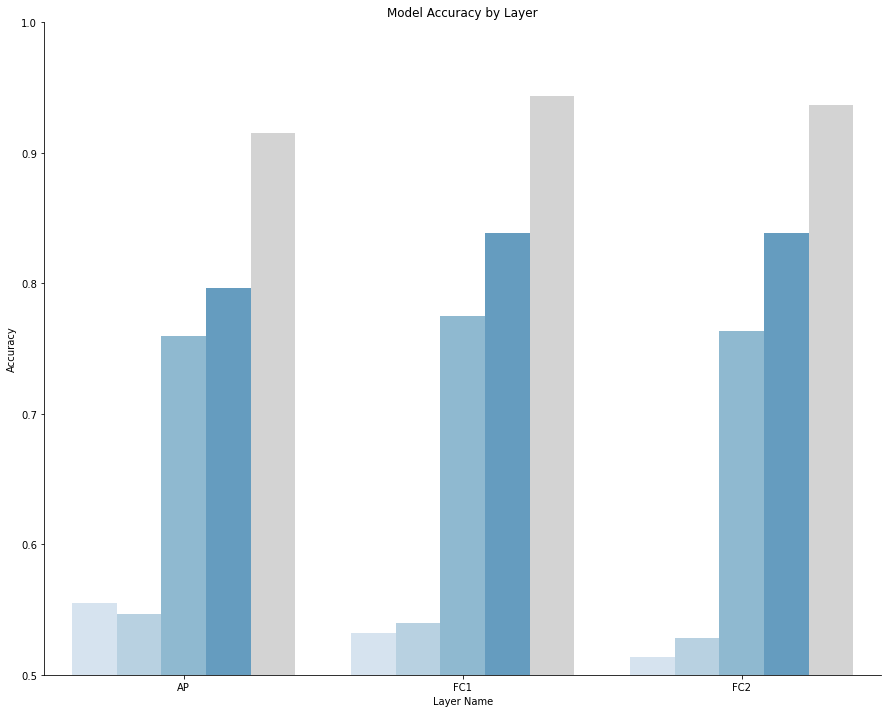

In [37]:
data = {
    'model_name': ['P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet'],
    
    'layer_name': ['AP', 'AP', 'AP', 'AP', 'AP',
                   'FC1','FC1','FC1','FC1','FC1',
                   'FC2','FC2','FC2','FC2','FC2'],
    
    'accuracy': [*bagnet_ap_mean_sal,
                *bagnet_fc1_mean_sal,
                *bagnet_fc2_mean_sal]
}

df = pd.DataFrame(data)

# Sample colors with RGB values
color_dict = {
    'P 11*11': (0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
    'P 17*17': (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
    'P 31*31': (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
    'P 33*33': (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
    'Standard Alexnet':(0.827, 0.827, 0.827)
}

# Create bar plot
plt.figure(figsize=(15, 12))
sns.barplot(data=df, x='layer_name', y='accuracy', hue='model_name', palette=color_dict, ci=None)

# Adding titles and labels
plt.title('Model Accuracy by Layer')
plt.xlabel('Layer Name')
plt.ylabel('Accuracy')
plt.legend(title='Model Name').remove()


plt.ylim(0.5, 1.0) 


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig('./dev/manuscript_figures/pinholenet_contour_training_classifier_head.png', bbox_inches='tight', format='png', dpi=600)
# Display the plot
plt.show()

# WORK IN PROGRESS